# DMRG of Heisenberg model on a ladder

Prepared by Tomohiro Soejima and Stefan Divic

We perform DMRG computation on the following spin-$\frac{1}{2}$ Hamiltonian

$$ H = - \sum_{i, \alpha} \vec{S_{i,\alpha}} \cdot \vec{S_{i+1, \alpha}} + J_2\sum_{i} \vec{S_{i,0}} \cdot \vec{S_{i, 1}}$$

where $\alpha = \{0, 1\}$ label the "legs". From Haldane-like physics, we expect this state to have a unique ground state for any $J_2 > 0$.

This model has been theoretically studied by mapping to a non-linear sigma model [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.53.R8848), and a bosonization based analysis can be found [here](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.67.064419). Both of them find a "Rung Singlet" state at any $J_2 > 0$.

In [306]:
import tenpy
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS
from tenpy.models.model import CouplingMPOModel
from tenpy.models.lattice import Ladder
from tenpy.algorithms import dmrg
import numpy as np
import matplotlib.pyplot as plt

In [314]:
class LadderHeisenberg(CouplingMPOModel):
    default_lattice = "Ladder"
    force_default_lattice = True
    
    def init_sites(self, model_param):
        return SpinHalfSite(conserve=None)
    
    def init_terms(self, model_params):
        J2 = model_params.get("J2", 0.1)
        J1 = model_params.get("J1", 1)
        # Add ferromagnetic coupling for legs u1 = 0, 1
        for u1 in range(2):
            self.add_coupling(-J1/2, u1, "Sp", u1, "Sm", 1, plus_hc = True)
            self.add_coupling(-J1, u1, "Sz", u1, "Sz", 1)
        # Add antiferromagnetic coupling between legs
        self.add_coupling(J2/2, 0, "Sp", 1, "Sm", 0, plus_hc = True)
        self.add_coupling(J2, 0, "Sz", 1, "Sz", 0)

In [312]:
def run_DMRG(J2, chi_max):
    model_params = {"J2":J2, "J1":1, "L":1, "bc_MPS":"infinite"}
    L = model_params["L"]
    model = LadderHeisenberg(model_params)
    psi = MPS.from_product_state(model.lat.mps_sites(), (["up","down"]*L), bc="infinite")
    dmrg_params = {
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-10,
            'trunc_cut': None
        },
        'update_env': 5,
        'start_env': 5,
        'max_E_err': 0.0001,
        'max_S_err': 0.0001,
        'max_sweeps': 200,
        'mixer': False
    }
    engine = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)
    engine.init_env(model=model)
    E0, psi = engine.run()
    psi.canonical_form()
    xi = psi.correlation_length()
    indices = [[0,1],[0,2],[1,3]] # MPS tensor indices for interleg coupling, intraleg coupling (leg 0), intraleg (leg 1)
    correlations = []
    # Measures components of S \cdot S
    for locs in indices:
        SxSx = psi.correlation_function("Sx", "Sx", [locs[0]],[locs[1]])
        SySy = psi.correlation_function("Sy", "Sy", [locs[0]],[locs[1]])
        SzSz = psi.correlation_function("Sz", "Sz", [locs[0]],[locs[1]])
        correlations.append([SxSx, SySy, SzSz])
    Sx = psi.expectation_value("Sx")
    Sy = psi.expectation_value("Sy")
    Sz = psi.expectation_value("Sz")
    return xi, np.array([Sx, Sy, Sz]), correlations

In [313]:
# values of chis and J2s to explore
chis = [2]#, 10, 100, 200]
J2s = [0.005]#, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

S_expectation_value  = np.zeros((len(chis), len(J2s), 2))
xis  = np.zeros((len(chis), len(J2s), 1))
correlations = {"interAFM":np.zeros((len(chis), len(J2s))), "intraFM0":np.zeros((len(chis), len(J2s))),
                "intraFM1":np.zeros((len(chis), len(J2s)))}

for i, chi in enumerate(chis):
    for j, J2 in enumerate(J2s):
        res_array2 = run_DMRG(J2, chi)
#         xis[i,j] = res_array[0]
#         S_expectation_value[i,j] = np.linalg.norm(res_array[1])
#         correlations["interAFM"][i,j] = np.sum(res_array[2][0])
#         correlations["intraFM0"][i,j] = np.sum(res_array[2][1])
#         correlations["intraFM1"][i,j] = np.sum(res_array[2][2])
        
# np.save("xis.npy", xis)
# np.save("S_expectation_values.npy", S_expectation_value)
# np.save("correlationsnpy", correlations)

In [301]:
plt.style.use("seaborn")
plt.rc("axes", labelsize=15)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

## There is a critical point at J2=0

Text(0, 0.5, '$\\xi$')

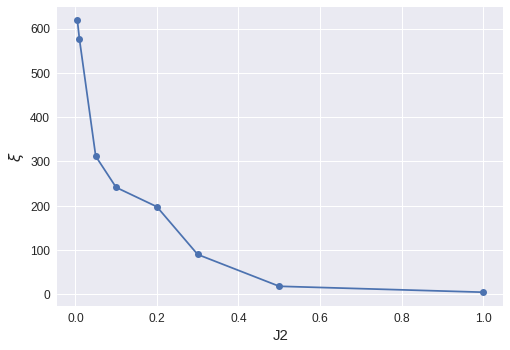

In [291]:
plt.plot(J2s, xis[-1,:], marker="o")
plt.xlabel("J2")
plt.ylabel(r"$\xi$")

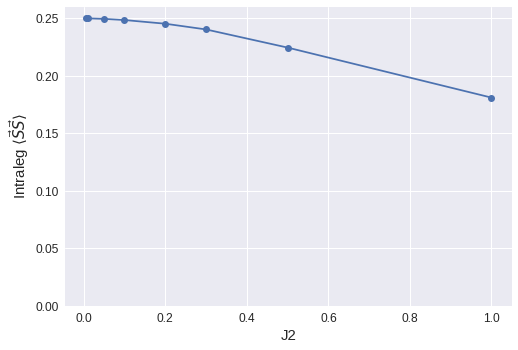

In [292]:
J2 = np.linspace(0,0.5)

for string in ["intraFM1"]:#correlations.keys():
    plt.plot(J2s, correlations[string][-1,:], label=string, marker="o")
    plt.xlabel("J2")
    plt.ylim([0,0.26])
    plt.ylabel(r"Intraleg $\langle \vec{S} \vec{S}\rangle$")

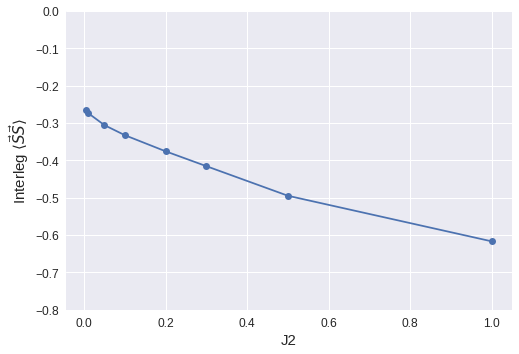

In [293]:
for string in ["interAFM"]:
    plt.plot(J2s, correlations[string][-1,:], label=string + f", J2={J2s[j]}", marker="o")
    plt.xlabel("J2")
    plt.ylim([-0.8, 0])
    plt.ylabel(r"Interleg $\langle \vec{S} \vec{S}\rangle$")

## Bound on ground state energy

We can write down a simple variational ground state to obtain an upper bound for the ground state energy.
Consider the following product state

$|\ldots \uparrow \uparrow\uparrow \ldots \rangle_{\text{leg}=0} \otimes |\ldots \downarrow \downarrow \downarrow \ldots \rangle_{\text{leg}=1}$

The energy of this state is $-1/2 - J_2/4$. This variational upperbound is plotted with the DMRG groundstate energy on the next plot.

Text(0, 0.5, 'Energy')

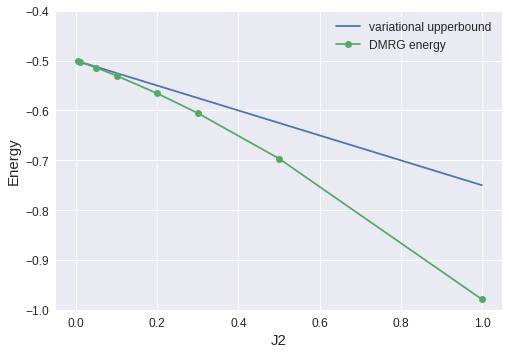

In [304]:
J2 = np.linspace(0,1)
plt.plot(J2, -1/4*2 - J2/4, label="variational upperbound")

J2_npa = np.array(J2s)
plt.plot(J2s, -2*correlations["intraFM0"][-1, :] + J2_npa * correlations["interAFM"][-1,:], marker="o", label="DMRG energy")
plt.legend()
plt.xlabel("J2")
plt.ylim([-1, -0.4])
plt.ylabel(r"Energy")

## Average magnetization is not converged well

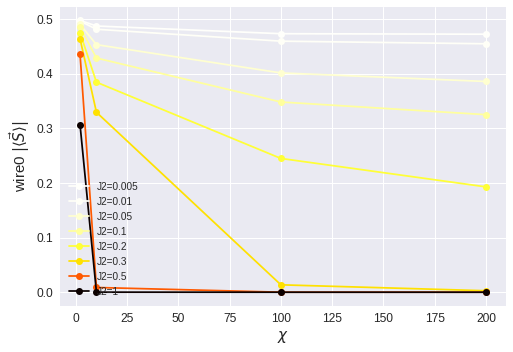

In [290]:
cmap = plt.get_cmap('hot_r')
colors = cmap(J2s)

for j in range(len(J2s)):
    plt.plot(chis, S_expectation_value[:,j,0], label=f"J2={J2s[j]}", marker="o", color=colors[j])
#     plt.plot(chis, S_expectation_value[:,j,1], label=f"wire1, J2={J2s[j]}")
    plt.legend()
    plt.xlabel(r"$\chi$")
    plt.ylabel(r"wire0 $|\langle \vec{S} \rangle|$")
#     plt.xlim()

### $S \cdot S$ is converged in $\chi$

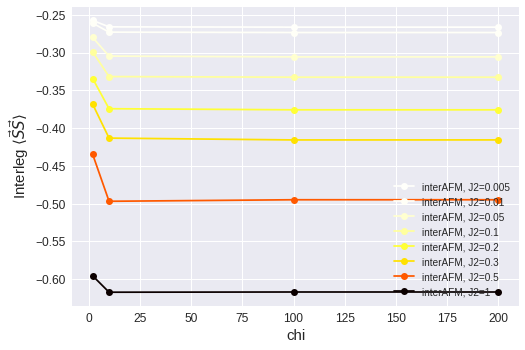

In [275]:
cmap = plt.get_cmap('hot_r')
colors = cmap(J2s)

for j in range(len(J2s)):
    for string in ["interAFM"]:#correlations.keys():
        plt.plot(chis, correlations[string][:,j], label=string + f", J2={J2s[j]}", marker="o", color=colors[j])
    #     plt.plot(chis, S_expectation_value[:,j,1], label=f"wire1, J2={J2s[j]}")
        plt.legend()
        plt.xlabel("chi")
        plt.ylabel(r"Interleg $\langle \vec{S} \vec{S}\rangle$")
    #     plt.xlim()

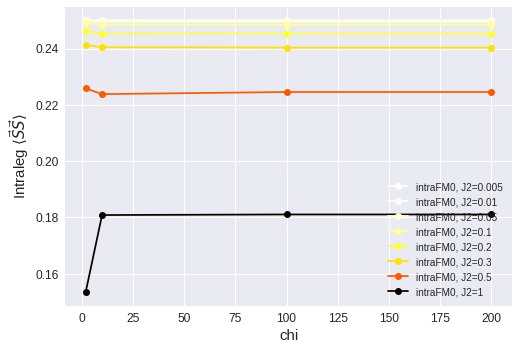

In [289]:
cmap = plt.get_cmap('hot_r')
colors = cmap(J2s)

for j in range(len(J2s)):
    for string in ["intraFM0"]:#correlations.keys():
        plt.plot(chis, correlations[string][:,j], label=string + f", J2={J2s[j]}", marker="o", color=colors[j])
        plt.legend()
        plt.xlabel("chi")
        plt.ylabel(r"Intraleg $\langle \vec{S} \vec{S}\rangle$")

### $\xi$ is not well converged

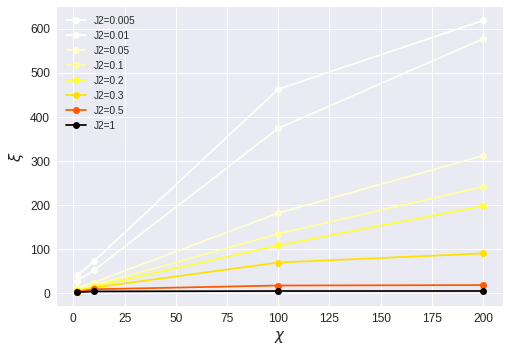

In [286]:
cmap = plt.get_cmap('hot_r')
colors = cmap(J2s)

for j in range(len(J2s)):
    plt.plot(chis, xis[:,j], label=f"J2={J2s[j]}", marker="o", color=colors[j])
    plt.legend()
    plt.xlabel(r"$\chi$")
    plt.ylabel(r"$\xi$")